## **Small Generative Pretrained Transformer:**

### Table of content

- **Import Libraries, check device, reproductibility**
- **Step 1: Dataset Loading & creation, Store loss values**
- **Step 2: Vocabulary size & Encoding / Decoding**
- **Step 3: Dataset Class and Sliding Window**
- **Step 4: Transformer Decoder Model**
- **Step 5: Model Training**
- **Step 6: Testing and Evaluation (Perplexity)**
- **Complete code**

### **Import Libraries, check device, reproductibility**

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import time
import math
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# check if cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Add a random seed for reproductibility
torch.manual_seed(42)
random.seed(42)

cuda


### **Step 1: Dataset Loading & creation, Store loss values**

In [3]:
results_dir = "./Results" # store loss (train & val results)
os.makedirs(results_dir, exist_ok=True) # Create dir if not existant
results_file_path = os.path.join(results_dir, "losses.txt")

In [4]:
file_path = "./dataset.txt"
with open(file_path, "r", encoding="utf-8") as f:
    data = f.read()

# Split Data into Train, Validation, and Test Sets (80%,10%,10%)
lines = data.splitlines(keepends=True) # Split /n into an array
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1
train_index = int(len(lines) * train_ratio)
val_index = train_index + int(len(lines) * val_ratio)
train_text = "".join(lines[:train_index])
val_text = "".join(lines[train_index:val_index])
test_text = "".join(lines[val_index:])

In [5]:
print(len(train_text))
print(len(val_text))
print(len(test_text))

907168
109074
99152


In [6]:
# Example
print(train_text[0:100]) # first 100 chars of the shakespear dataset
print("--------------")
print(test_text[-100:]) # last 100 chars of the shakespear dataset

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
--------------
TONIO:
Noble Sebastian,
Thou let'st thy fortune sleep--die, rather; wink'st
Whiles thou art waking.



### **Step 2: Vocabulary size & Encoding / Decoding**

In [7]:
text = "".join(lines) # Gets entire dataset
chars = sorted(list(set(text))) # list of unique tokens (here character-level)
# Output:
vocab_size = len(chars)
string_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_string = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

In [8]:
# Example
print(chars)
print(vocab_size)
print(encode("AN !"))
print(decode(encode("AN !")))

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
65
[13, 26, 1, 2]
AN !


### **Step 3: Dataset Class and Sliding Window**

In [9]:
class CharDataset(Dataset):
    def __init__(self, text):
        # Return tensor of input ids [13,15...]
        self.data = torch.tensor(encode(text), dtype=torch.long)

    def __len__(self):
        # Get length - block_size to not have an Out-of-Bounds Exception
        # Last chunk: position len(self.data) - block_size
        return len(self.data) - block_size

In [10]:
# Example
test_dataset = CharDataset(test_text)
block_size = 2
total_chunks = len(test_dataset)
print(f"Total number of chunks: {total_chunks}")

Total number of chunks: 99150


In [11]:
# Generate one batch of batch size (e.g B = 2 = 2 sequences)
def get_sliding_window_batch(dataset, step_size):
    data = dataset.data # Get dataset
    windows, targets = [], []
    # Iterate over 0, length(dataset)-1 to stay within bound
    # Use step_size to control how much the starting point shifts between consecutive windows
    for i in range(0, len(data)-block_size, step_size):
        windows.append(data[i:i + block_size])
        targets.append(data[i + 1:i + block_size + 1]) # offset by one
    # Combine list of all sequences into tensors: 2D (total_windows, block_size)
    windows = torch.stack(windows)
    targets = torch.stack(targets)
    # Random permutation of indices
    # [:batch_size] random sequences from 2D tensor of all windows for mini-batch
    indices = torch.randperm(len(windows))[:batch_size]
    # Move the selected batch (windows and targets) to the specified device (CPU or GPU (parallel)) for computation
    # e.g windows[3,1]
    return windows[indices].to(device), targets[indices].to(device) # 2D tensors (B,T)

In [12]:
# Example
block_size = 20
batch_size = 2
test_dataset = CharDataset(test_text)

windows, targets = get_sliding_window_batch(test_dataset, step_size=10)
print("Windows Shape:", windows.shape)
print("Targets Shape:", targets.shape)

for i in range(batch_size):
    print(f"\nBatch {i+1}:")
    print(f"Sequence (Encoded): {windows[i].tolist()}")
    print(f"Sequence (Decoded): {decode(windows[i].tolist())}")
    print(f"Target (Encoded): {targets[i].tolist()}")
    print(f"Target (Decoded): {decode(targets[i].tolist())}")

# Result: we can see here that the two batches contains two different sequences
# Because batch sequences are randomly sampled from the entire dataset
# Dataset is large and batch size small so two sequences are completely different
# Ensures training diversity

Windows Shape: torch.Size([2, 20])
Targets Shape: torch.Size([2, 20])

Batch 1:
Sequence (Encoded): [56, 57, 43, 6, 1, 51, 63, 1, 53, 62, 6, 1, 51, 63, 1, 39, 57, 57, 6, 1]
Sequence (Decoded): rse, my ox, my ass, 
Target (Encoded): [57, 43, 6, 1, 51, 63, 1, 53, 62, 6, 1, 51, 63, 1, 39, 57, 57, 6, 1, 51]
Target (Decoded): se, my ox, my ass, m

Batch 2:
Sequence (Encoded): [56, 43, 1, 39, 52, 42, 1, 58, 46, 43, 56, 43, 1, 54, 47, 43, 41, 43, 42, 1]
Sequence (Decoded): re and there pieced 
Target (Encoded): [43, 1, 39, 52, 42, 1, 58, 46, 43, 56, 43, 1, 54, 47, 43, 41, 43, 42, 1, 61]
Target (Decoded): e and there pieced w


In [13]:
# Example
# Step size: It only controls how much the starting point of each window shifts in the dataset
# larger step size helps cover the dataset more efficiently for large datasets
# `block_size // 2` balances dataset coverage and efficiency by reducing redundancy while still capturing overlapping context between sequences.

test = "abcdefghij"  # Simple sentence
block_size = 4  # Length of each chunk
step_size_1 = 1  # Step size = 1
step_size_2 = 2  # Step size = 2

# Function to demonstrate step size
def illustrate_step_size(text, block_size, step_size):
    chars = list(text)
    sequences = []
    for i in range(0, len(chars) - block_size + 1, step_size):
        sequences.append(chars[i:i + block_size])
    return sequences

# Example with step size = 1
sequences_step_1 = illustrate_step_size(test, block_size, step_size_1)
print("Step Size = 1:")
for seq in sequences_step_1:
    print("".join(seq))

# Example with step size = 2
sequences_step_2 = illustrate_step_size(test, block_size, step_size_2)
print("\nStep Size = 2:")
for seq in sequences_step_2:
    print("".join(seq))

Step Size = 1:
abcd
bcde
cdef
defg
efgh
fghi
ghij

Step Size = 2:
abcd
cdef
efgh
ghij


### **Step 4: Transformer Decoder Model**

In [14]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        # nn.Linear: (in_features=, out_features=)
        # Performs the operation Y = XW^T + b, where W is stored as (out_features, in_features) and is transposed internally for computation.
        self.query = nn.Linear(n_embd, head_size, bias=False)  # Query projection (n_embed,hs)
        self.key = nn.Linear(n_embd, head_size, bias=False)    # Key projection   (in=n_embed,out=hs)
        self.value = nn.Linear(n_embd, head_size, bias=False)  # Value projection (n_embed,hs)
        # Lower triangular Mask (T,T) for Causal Attention
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)  # Regularization

    def forward(self, x):
        B, T, C = x.shape
        q = self.query(x) # Q: (B,T,C) -> (B,T,hs)
        k = self.key(x)   # K: (B,T,C) -> (B,T,hs)
        v = self.value(x) # V: (B,T,C) -> (B,T,hs)
        # Attention scores (dot-product)
        #   Transpose K on the last two dim.: (T,hs)
        #   Divide by sqrt(head_size) = k.shape[-1] # Last dimension
        wei = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5  # (B,T,hs) @ (B,hs,T) -> (B,T,T)
        # Apply causal mask to prevent attenting future tokens
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # Apply lower mask and replace 0 with -inf (B,T,T)
        wei = F.softmax(wei, dim=-1)  # Apply softmax on last dim (row-wise) (B,T,T)
        wei = self.dropout(wei) # Apply dropout (B,T,T)
        out = wei @ v  # Weighted sum  (B,T,T)@(B,T,hs) -> (B,T,hs)
        return out # (B,T,hs)

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        # ModuleList: Parallel processing of multiple heads
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # (B,T,C)->(B,T,hs)

        # Linear Projection to combine outputs of all heads
        self.proj = nn.Linear(head_size * num_heads, n_embd) # (B,T,hs*num_head) -> (B,T,n_embd)
        self.dropout = nn.Dropout(dropout)  # Regularization

    def forward(self, x):
        # Concatenate outputs of all heads along last dimension
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # (B,T,hs*num_heads)

        # Project concatenated output back to the embed dimension
        out = self.dropout(self.proj(out)) # (B,T,n_embd)

        return out # (B,T,n_embd)

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        # Two linear layers with hidden size 4*n_embd
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # Expand embedding size (4*n_embd)
            nn.ReLU(),                      # Non-linearity ReLU
            nn.Linear(4 * n_embd, n_embd),  # Project back to embedding size (n_embd)
            nn.Dropout(dropout),            # Regularization
        )

    def forward(self, x):
        return self.net(x) # (B,T,n_emdb)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        # Calculate head size (split embedding accross heads)
        head_size = n_embd // n_head

        # Multi-Head Attention
        self.sa = MultiHeadAttention(n_head, head_size)  # (B,T,n_embd) -> (B,T,n_embd)
        self.ln1 = nn.LayerNorm(n_embd)  # Layer normalization
        self.ffwd = FeedForward(n_embd)  # Feed-forward network
        self.ln2 = nn.LayerNorm(n_embd)  # Layer normalization

    # Here Pre-Norm - better for Decoder (stabilizes training)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))  # Normalize And Add
        x = x + self.ffwd(self.ln2(x))# Normalize and Add
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size): # vocab_size as input
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)     # Token Emb Table (vocab_size,n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)  # Pos. Emb Table  (block_size, n_embed)

        # Sequential Blocks (stacks Transformer Blocks of shape (n_embed,n_head))
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)  # Layer Nrom (n_embed)
        self.lm_head = nn.Linear(n_embd, vocab_size)  # LM Head (n_embed, vocab_size)
        self.apply(self._init_weights)  # Initialize weights

    # Initialize weights of Linear Layer and Embedding Table (mean=0, std=0.02)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape  # index: (B,T)
        tok_emb = self.token_embedding_table(index)  # Token emb. (B, T, C)
        # Creates a sequence T [0,T-1]
        pos_emb = self.position_embedding_table(torch.arange(T, device=index.device))  # Pos. Emb. (T,C)
        # x output: (B,T,C)
        x = tok_emb + pos_emb  # Add Tok. Emb and Pos. Emb through broadcasting (B,T,C)+(T,C) = (B,T,C)
        x = self.blocks(x)  # Through transformer blocks output (B,T,C)
        x = self.ln_f(x)  # Layer norm on last dim C, output (B,T,C)
        # Maps (B,T,C) to (B,T,vocab_size) => Linear transformation
        logits = self.lm_head(x)  # Logits (B, T, vocab_size)
        if targets is None:
            loss = None
        else:
            logits = logits.view(B * T, -1) # Converts (B,T,vocab_size) to (B*T, vocab_size) without affecting last dim
            targets = targets.view(B * T)   # Flatten targets to 1D Tensor
            loss = F.cross_entropy(logits, targets)  # Compute loss (softmax done internally)
        return logits, loss

    def generate(self, index, max_new_tokens): # Here B=1
        for _ in range(max_new_tokens): # Loop until max_new_tokens
            index_cond = index[:, -block_size:]  # Take last block_size tokens (B,T)
            logits, _ = self.forward(index_cond)  # Logits (B,T,vocab_size)
            logits = logits[:, -1, :]  # Get logits of last token in index_cond (B,vocab_size)
            probs = F.softmax(logits, dim=-1)  # Softmax for prob => (B,vocab_size) on last dim vocab
            index_next = torch.multinomial(probs, num_samples=1)  # Sample next token (B,1)
            index = torch.cat((index, index_next), dim=1)  # Append to sequence: (B,seq_length + 1)
        return index

### **Step 5: Model Training**

In [15]:
# Initialize training, validation and test
train_dataset = CharDataset(train_text)
val_dataset = CharDataset(val_text)
test_dataset = CharDataset(test_text)

In [16]:
# Define the parameters (added here just as test - faster execution)
batch_size = 128
block_size = 128
max_iters = 600 #1400
learning_rate = 3e-4
eval_iters = 50 #100
n_embd = 512
n_head = 8
n_layer = 6
dropout = 0.2

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GPTLanguageModel(vocab_size).to(device) # Define Model
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) # Define Optimizer and Learning Rate
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_iters) # Define Scheduler

In [18]:
# Track best validation loss for model saving
best_val_loss = float('inf')
train_losses, val_losses = [], []

# Start timing
start_time = time.time()

# Compute evaluation on both training and validation sets
for iter in range(max_iters): # Loop through all iterations
    if iter % eval_iters == 0: # Switch to eval mode
        model.eval() # Disables dropout
        with torch.no_grad(): # Stops gradient computation
            train_loss, val_loss = 0.0, 0.0
            # Loop through training and validation datasets (compute avg for train and val)
            for split, dataset in zip(['train', 'val'], [train_dataset, val_dataset]):
                total_loss = 0.0
                # For train and val, run evaluation for eval iters
                for _ in range(eval_iters):
                    xb, yb = get_sliding_window_batch(dataset, step_size=block_size // 2) # get batches
                    logits, loss = model(xb, yb) # compute logits and loss
                    total_loss += loss.item() # Accumulate loss values
                avg_loss = total_loss / eval_iters # Compute avg loss
                if split == 'train':
                    train_losses.append(avg_loss)
                else:
                    # Track best validation loss
                    val_losses.append(avg_loss)
                    if avg_loss < best_val_loss:
                        best_val_loss = avg_loss
                        torch.save(model.state_dict(), "best_model.pth")

        with open(results_file_path, "w") as f:
            f.write(f"Train Losses: {train_losses}\n")
            f.write(f"Validation Losses: {val_losses}\n")

        print(f"Iteration {iter}: Train Loss {train_losses[-1]:.3f}, Val Loss {val_losses[-1]:.3f}")

    model.train() # Enable dropout and gradient tracking
    xb, yb = get_sliding_window_batch(train_dataset, step_size=block_size // 2)
    logits, loss = model(xb, yb) # Compute logits
    optimizer.zero_grad(set_to_none=True) # Clear previous gradients to avoid accumulation
    loss.backward() # Compute gradients of the loss using backpropagation
    #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping (prevent exploding gradients)
    optimizer.step() # Update the model parameters using computed gradients
    #scheduler.step() # Ajust learning rate according to scheduler


# End timing
end_time = time.time()
training_time = end_time - start_time
training_time_minutes = training_time / 60
print(f"Total training time: {training_time_minutes:.2f} minutes")


# Save Final Model
torch.save(model.state_dict(), 'final_model.pth')

Iteration 0: Train Loss 4.328, Val Loss 4.329
Iteration 50: Train Loss 3.063, Val Loss 3.087
Iteration 100: Train Loss 2.558, Val Loss 2.597
Iteration 150: Train Loss 2.464, Val Loss 2.509
Iteration 200: Train Loss 2.351, Val Loss 2.403
Iteration 250: Train Loss 2.197, Val Loss 2.257
Iteration 300: Train Loss 2.036, Val Loss 2.109
Iteration 350: Train Loss 1.913, Val Loss 2.012
Iteration 400: Train Loss 1.807, Val Loss 1.921
Iteration 450: Train Loss 1.723, Val Loss 1.854
Iteration 500: Train Loss 1.662, Val Loss 1.803
Iteration 550: Train Loss 1.602, Val Loss 1.760
Total training time: 7.31 minutes


#### **Plot Loss functions**

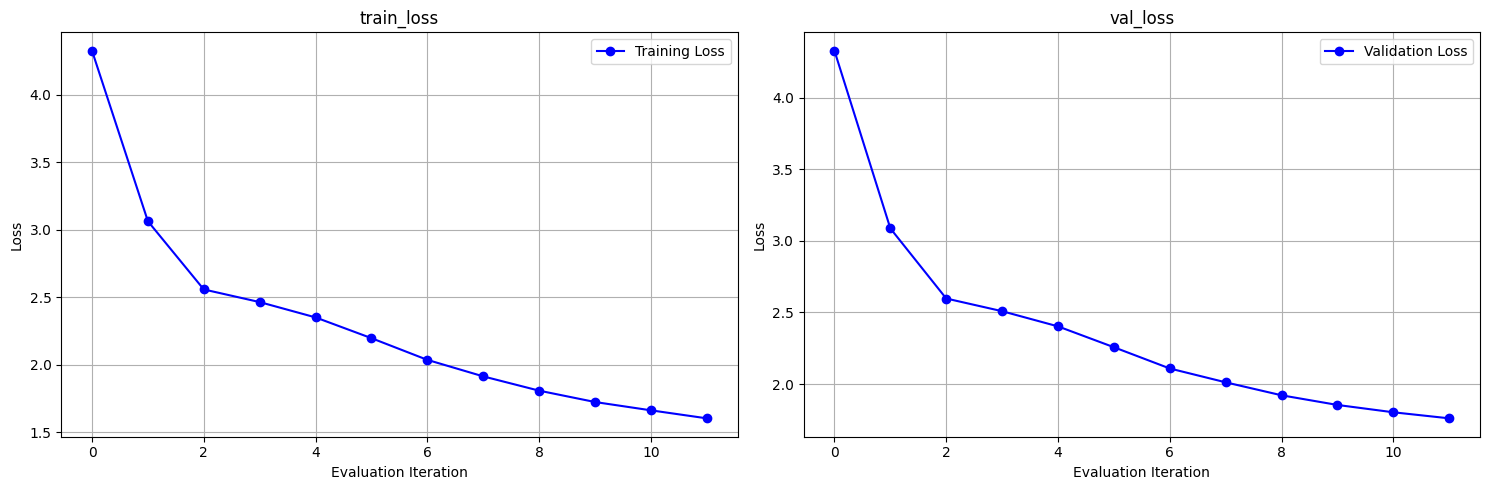

In [19]:
# Read the content from the results.txt file
with open("./Results/losses.txt", "r") as results_file:
    content = results_file.readlines()

# Extract train losses, validation losses, and other metrics from the file
train_losses = []
val_losses = []

for line in content:
    if line.startswith("Train Losses:"):
        train_losses = eval(line.split(":", 1)[1].strip())  # Convert string to list
    elif line.startswith("Validation Losses:"):
        val_losses = eval(line.split(":", 1)[1].strip())  # Convert string to list


# Plotting both training and validation losses in the same row
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training loss plot
axes[0].plot(range(len(train_losses)), train_losses, label='Training Loss', color='blue', marker='o')
axes[0].set_xlabel('Evaluation Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('train_loss')
axes[0].grid(True)
axes[0].legend()

# Validation loss plot
axes[1].plot(range(len(val_losses)), val_losses, label='Validation Loss', color='blue', marker='o')
axes[1].set_xlabel('Evaluation Iteration')
axes[1].set_ylabel('Loss')
axes[1].set_title('val_loss')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

### **Step 7: Testing and Evaluation (Perplexity)**

In [20]:
window_losses = []

# Process the test dataset in sliding windows of block_size
for start in range(0, len(test_dataset.data) - block_size, block_size):
    # Create input (xb) and target (yb) sequences for this batch
    xb = test_dataset.data[start:start + block_size].unsqueeze(0).to(device)
    yb = test_dataset.data[start + 1:start + block_size + 1].unsqueeze(0).to(device)

    # Compute logits and loss without gradient computation
    with torch.no_grad():
        logits, loss = model(xb, yb)
        window_losses.append(loss.item())  # Append the average loss for this window

# Compute average loss and standard deviation
avg_test_loss = np.mean(window_losses)
std_test_loss = np.std(window_losses)

# Convert average loss to perplexity
perplexity = math.exp(avg_test_loss)
perplexity_std = math.exp(std_test_loss)

print(f"Test Perplexity: {perplexity:.3f} ± {perplexity_std:.3f}")

Test Perplexity: 6.989 ± 1.230


In [21]:
model.eval() # Eval mode: disable dropout
with torch.no_grad(): # No gradients computed
    seed = "O God, O God!"
    # Encodes sequence
    # unsqueeze(0) adds a batch dimension (1) to become (1,T)
    context = torch.tensor(encode(seed), dtype=torch.long).unsqueeze(0).to(device)
    generated_tokens = model.generate(context, max_new_tokens=700) # Generate prediction IDs
    generated_text = decode(generated_tokens[0].tolist()) # Convert back to text
    print(f"Generated Text:\n{generated_text}")

Generated Text:
O God, O God!

LADY CAPULET:
I am peoposesion their:
What. At old sheep the would broye-what such off,
And the fair have hose of our feirst hath lever made,
That forwhoes seen to the chourse? the hospend, that tlet is side;
For for a slong ousbidy's moces think I live made,
To that is none ful apoker 's mand. Good the brother ginne,
Ag, of make see dead that I own hearth is am
And daughter vilty Perchant: such my niche give is till.

LEONTES:
Ull fair for beed.

CORIOLANUS:
No more is a prespect on the well of Amorm, life,
For that of purpromony pity fear roscing the counself our and
We faals you seem of moster in father.

PRINCE EDWARD IO:
Ay, are to her will to-true hereher much ond more made.

FRIAR V


### **Complete code**

- Possible to run directly this code (just import dataset.txt)

In [22]:
# Import Libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import time
import math
import random
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
random.seed(42)

results_dir = "./Results"
os.makedirs(results_dir, exist_ok=True)
results_file_path = os.path.join(results_dir, "losses.txt")

file_path = "./dataset.txt"
with open(file_path, "r", encoding="utf-8") as f:
    data = f.read()

lines = data.splitlines(keepends=True)
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1
train_index = int(len(lines) * train_ratio)
val_index = train_index + int(len(lines) * val_ratio)
train_text = "".join(lines[:train_index])
val_text = "".join(lines[train_index:val_index])
test_text = "".join(lines[val_index:])

text = "".join(lines)
chars = sorted(list(set(text)))
vocab_size = len(chars)
string_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_string = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

class CharDataset(Dataset):
    def __init__(self, text):
        self.data = torch.tensor(encode(text), dtype=torch.long)
    def __len__(self):
        return len(self.data) - block_size

def get_sliding_window_batch(dataset, step_size):
    data = dataset.data
    windows, targets = [], []
    for i in range(0, len(data) -block_size, step_size):
        windows.append(data[i:i + block_size])
        targets.append(data[i + 1:i + block_size + 1])
    windows = torch.stack(windows)
    targets = torch.stack(targets)
    indices = torch.randperm(len(windows))[:batch_size]
    return windows[indices].to(device), targets[indices].to(device)

# Transformer code
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ffwd = FeedForward(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        tok_emb = self.token_embedding_table(index)
        pos_emb = self.position_embedding_table(torch.arange(T, device=index.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            logits = logits.view(B * T, -1)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, index, max_new_tokens):
        for _ in range(max_new_tokens):
            index_cond = index[:, -block_size:]
            logits, _ = self.forward(index_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            index_next = torch.multinomial(probs, num_samples=1)
            index = torch.cat((index, index_next), dim=1)
        return index
# Transformer code

# Define the parameters
batch_size = 128
block_size = 128
max_iters = 600
learning_rate = 3e-4
eval_iters = 50
n_embd = 512
n_head = 8
n_layer = 6
dropout = 0.2

train_dataset = CharDataset(train_text)
val_dataset = CharDataset(val_text)
test_dataset = CharDataset(test_text)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GPTLanguageModel(vocab_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

best_val_loss = float('inf')
train_losses, val_losses = [], []

start_time = time.time()

for iter in range(max_iters):
    if iter % eval_iters == 0:
        model.eval()
        with torch.no_grad():
            train_loss, val_loss = 0.0, 0.0
            for split, dataset in zip(['train', 'val'], [train_dataset, val_dataset]):
                total_loss = 0.0
                for _ in range(eval_iters):
                    xb, yb = get_sliding_window_batch(dataset, step_size=block_size // 2)
                    logits, loss = model(xb, yb)
                    total_loss += loss.item()
                avg_loss = total_loss / eval_iters
                if split == 'train':
                    train_losses.append(avg_loss)
                else:
                    val_losses.append(avg_loss)
                    if avg_loss < best_val_loss:
                        best_val_loss = avg_loss
                        torch.save(model.state_dict(), "best_model.pth")
        with open(results_file_path, "w") as f:
            f.write(f"Train Losses: {train_losses}\n")
            f.write(f"Validation Losses: {val_losses}\n")

        print(f"Iteration {iter}: Train Loss {train_losses[-1]:.3f}, Val Loss {val_losses[-1]:.3f}")

    model.train()
    xb, yb = get_sliding_window_batch(train_dataset, step_size=block_size // 2)
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

end_time = time.time()
training_time = (end_time - start_time) / 60
print(f"Total training time: {training_time:.2f} minutes")
torch.save(model.state_dict(), 'final_model.pth')

Iteration 0: Train Loss 4.362, Val Loss 4.359
Iteration 50: Train Loss 2.997, Val Loss 3.017
Iteration 100: Train Loss 2.529, Val Loss 2.569
Iteration 150: Train Loss 2.441, Val Loss 2.486
Iteration 200: Train Loss 2.285, Val Loss 2.337
Iteration 250: Train Loss 2.106, Val Loss 2.167
Iteration 300: Train Loss 1.981, Val Loss 2.066
Iteration 350: Train Loss 1.851, Val Loss 1.951
Iteration 400: Train Loss 1.763, Val Loss 1.879
Iteration 450: Train Loss 1.684, Val Loss 1.818
Iteration 500: Train Loss 1.623, Val Loss 1.757
Iteration 550: Train Loss 1.577, Val Loss 1.727
Total training time: 7.33 minutes


In [23]:
window_losses = []

for start in range(0, len(test_dataset.data) - block_size, block_size):
    xb = test_dataset.data[start:start + block_size].unsqueeze(0).to(device)
    yb = test_dataset.data[start + 1:start + block_size + 1].unsqueeze(0).to(device)

    with torch.no_grad():
        logits, loss = model(xb, yb)
        window_losses.append(loss.item())

avg_test_loss = np.mean(window_losses)
std_test_loss = np.std(window_losses)

perplexity = math.exp(avg_test_loss)
perplexity_std = math.exp(std_test_loss)

print(f"Test Perplexity: {perplexity:.3f} ± {perplexity_std:.3f}")

model.eval()
with torch.no_grad():
    seed = "O God, O God!"
    context = torch.tensor(encode(seed), dtype=torch.long).unsqueeze(0).to(device)
    generated_tokens = model.generate(context, max_new_tokens=700)
    generated_text = decode(generated_tokens[0].tolist())
    print(f"Generated Text:\n{generated_text}")

Test Perplexity: 6.865 ± 1.235
Generated Text:
O God, O God!
I vole? my lied, I doe to noign their may mine hold
And pity's buse enemers, not with at tends
A fair hboth my forth's feirs thumbless. God somanly frienders,
And oppy sting wair proves.
What hath let is side; what that be but exby you
Why be thee cheek that in minkle melf;
The you had best we by doth me, be I will not he,
Unsife thee dread unglemon when Valice!

AUMILLO:
Is could he dispit: suck my night go stroke
Agaves great with frant of begdive: seem, then more!
His all Relance you Volscel
To me.

GLOUCESTER:
Please purpronour pity your gracian,
And my lord my bear perful:
Oyeads he made the likefore ittes:
You happy kneed bleast of hell.

ROMEO:
He hereher; let ond you, my bread,
And 


#### **Plot Results**

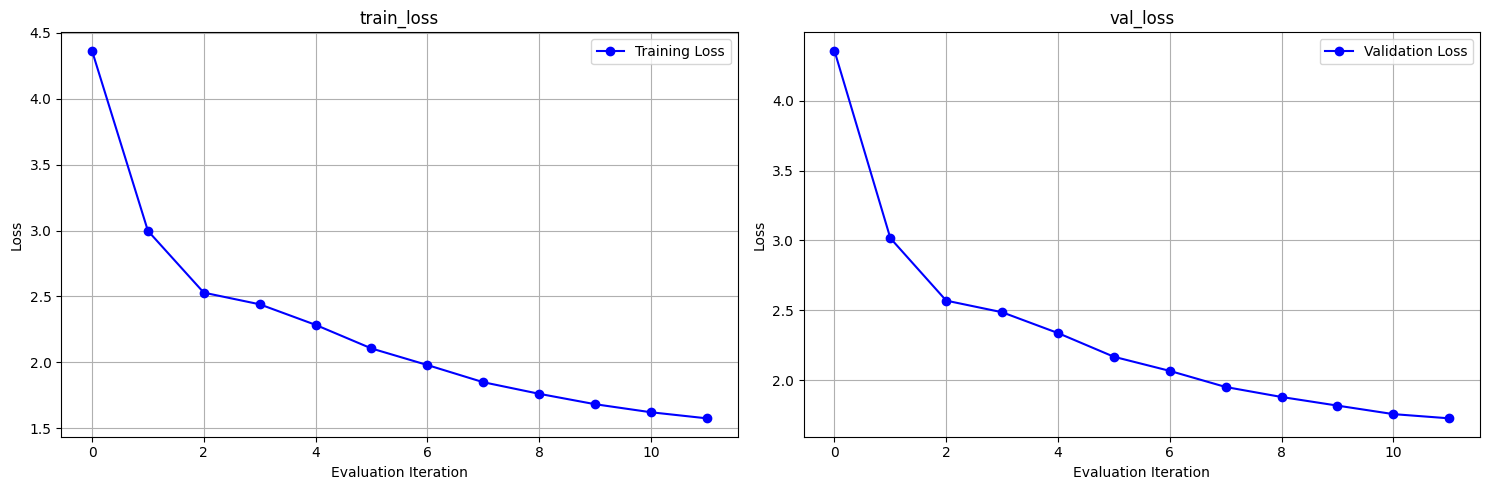

In [24]:
with open("./Results/losses.txt", "r") as results_file:
    content = results_file.readlines()

train_losses = []
val_losses = []

for line in content:
    if line.startswith("Train Losses:"):
        train_losses = eval(line.split(":", 1)[1].strip())
    elif line.startswith("Validation Losses:"):
        val_losses = eval(line.split(":", 1)[1].strip())


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(len(train_losses)), train_losses, label='Training Loss', color='blue', marker='o')
axes[0].set_xlabel('Evaluation Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('train_loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(range(len(val_losses)), val_losses, label='Validation Loss', color='blue', marker='o')
axes[1].set_xlabel('Evaluation Iteration')
axes[1].set_ylabel('Loss')
axes[1].set_title('val_loss')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()